In [1]:
import os
import time
import json
import pickle
import timeit
import random
import param
import shutil
import collections
import numpy as np
import tensorflow as tf

import stctrain
import datahelper
import stctokenizer
import nuggetdetection as ND
import dialogquality as DQ
import dialogquality_ndfeature as DQNDF
import stcevaluation as STCE

from scipy import stats
from collections import Counter
from gensim.models import Word2Vec
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

import logging
logging.basicConfig(level=logging.INFO)

Using TensorFlow backend.


In [2]:
doclen = param.doclen
embsize = param.embsize
max_sent = param.max_sent
NDclasses = param.NDclasses
DQclasses = param.DQclasses
sentembsize = param.sentembsize

REMOVE_STOPWORDS = False
TO_LOWER = True
TOKEN_TYPE = 'nltk'

datahelper = datahelper.DataHelper(embedding_path="../embedding/STCWiki/STCWiki_mincount0.model.bin")
stctokenizer = stctokenizer.STCTokenizer()

INFO:gensim.utils:loading Word2VecKeyedVectors object from ../embedding/STCWiki/STCWiki_mincount0.model.bin
INFO:gensim.utils:loading vectors from ../embedding/STCWiki/STCWiki_mincount0.model.bin.vectors.npy with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:loaded ../embedding/STCWiki/STCWiki_mincount0.model.bin


## Word Embedding

In [3]:
# corpus = datahelper.prepare_word_embedding_corpus(
#     '../data/text8', 
#     TOKEN_TYPE, 
#     REMOVE_STOPWORDS, 
#     TO_LOWER,
# )

# wordemb_model = Word2Vec(corpus, size=300, min_count=0, workers=4, iter=25)
# word_vectors = wordemb_model.wv
# datahelper.test_w2v_model(word_vectors, word='problem', topn=10)

# 儲存訓練好的word2vec模型，因為已經訓練並儲存好了所以註解掉
# word_vectors.save("../embedding/STCWiki/STCWiki_mincount0.model.bin")
# datahelper.set_word_vectors(word_vectors)

## Read Corpus & Prepare data for model

In [4]:
trainX, trainND, trainDQ, train_turns, train_masks = datahelper.get_model_train_data(
    'train',
    TOKEN_TYPE, 
    REMOVE_STOPWORDS, 
    TO_LOWER,
)

devX, devND, devDQ, dev_turns, dev_masks = datahelper.get_model_train_data(
    'dev',
    TOKEN_TYPE, 
    REMOVE_STOPWORDS, 
    TO_LOWER,
)

testX, test_turns, test_masks = datahelper.get_model_test_data(token_type='nltk', remove_stopwords=False, to_lower=True)

testIDs = datahelper.testIDs
trainDQA = [item['A'] for item in trainDQ]
trainDQS = [item['S'] for item in trainDQ]
trainDQE = [item['E'] for item in trainDQ]
devDQA = [item['A'] for item in devDQ]
devDQS = [item['S'] for item in devDQ]
devDQE = [item['E'] for item in devDQ]

INFO:corpus word2vec:Training data unknown words count: 0
INFO:corpus word2vec:Training data unknown words count: 0
INFO:corpus word2vec:Testing data unknown words count: 0


In [5]:
dataND = [trainX, trainND, train_turns, train_masks, devX, devND, dev_turns, dev_masks, testX, test_turns, test_masks]
dataDQA = [trainX, trainDQA, train_turns, devX, devDQA, dev_turns, testX, test_turns]
dataDQS = [trainX, trainDQS, train_turns, devX, devDQS, dev_turns, testX, test_turns]
dataDQE = [trainX, trainDQE, train_turns, devX, devDQE, dev_turns, testX, test_turns]

In [6]:
es = 3
fixed_paramsND  = {'epoch':50, 'early_stopping':es, 'batch_size':30, 'lr':0.001, 'kp':1, 'hiddens':1024, 'Fsize':[2,2]} 
fixed_paramsDQA = {'scoretype':'DQA', 'epoch':50, 'early_stopping':es, 'batch_size':40, 'kp':1, 'lr':0.001, 'hiddens':1024, 'Fsize':[2,2]} 
fixed_paramsDQS = {'scoretype':'DQS', 'epoch':50, 'early_stopping':es, 'batch_size':40, 'kp':1, 'lr':0.001, 'hiddens':1024, 'Fsize':[2,2]} 
fixed_paramsDQE = {'scoretype':'DQE', 'epoch':50, 'early_stopping':es, 'batch_size':40, 'kp':1, 'lr':0.001, 'hiddens':1024, 'Fsize':[2,2]} 

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def show_train_history(title, train, valid, earlystop=es):
    epoch = len(train)
    best = epoch-earlystop
    x = [i for i in range(1, epoch + 1)]
    plt.figure(figsize=(5,12))
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.rcParams.update({'font.size': 18})
    plt.plot(x, train, marker='o', linestyle='-', color='b')
    plt.plot(x, valid, marker='o', linestyle='-', color='r')
    plt.axvline(best, color='black')
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
    plt.show()

## Test ND

In [8]:
BEST_PATH = 'ResultPickle/'
# bestND = pickle.load(open(BEST_PATH + 'bestND.p', "rb"))
bestDQAs = pickle.load(open(BEST_PATH + 'memoryDQAs.p', "rb"))
bestDQSs = pickle.load(open(BEST_PATH + 'memoryDQSs.p', "rb"))
bestDQEs = pickle.load(open(BEST_PATH + 'memoryDQEs.p', "rb"))

MemoryNone_GatingFalse_CNNRNN_1stack_rnnLayer1


INFO:Training:CNNRNN|12|False|True|2_2|1024|256|1|0.02700|0.09982


<Figure size 360x864 with 0 Axes>

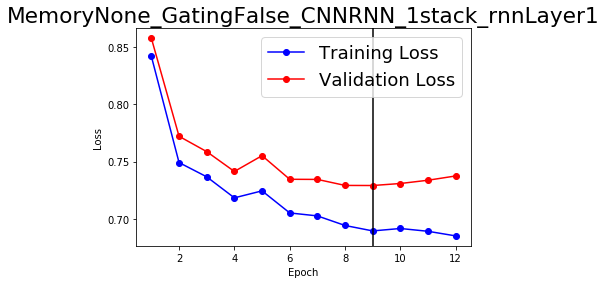

MemoryNone_GatingFalse_CNNRNN_2stack_rnnLayer1


INFO:Training:CNNRNN|10|False|True|2_2|1024|256_512|1|0.02612|0.09660


<Figure size 360x864 with 0 Axes>

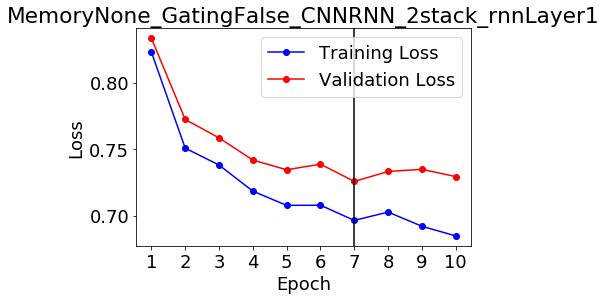

MemoryNone_GatingFalse_CNNRNN_3stack_rnnLayer1


INFO:Training:CNNRNN|15|False|True|2_2|1024|256_512_1024|1|0.02576|0.09724


<Figure size 360x864 with 0 Axes>

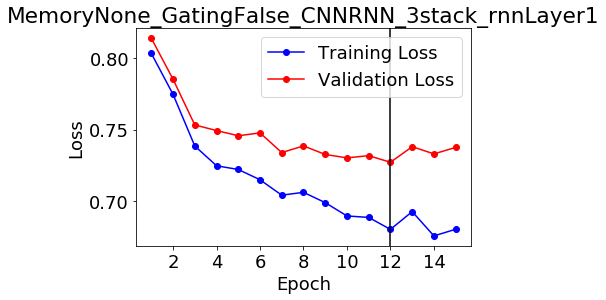

MemoryNone_GatingFalse_CNNRNN_1stack_rnnLayer2


INFO:Training:CNNRNN|14|False|True|2_2|1024|256|1|0.02592|0.09650


<Figure size 360x864 with 0 Axes>

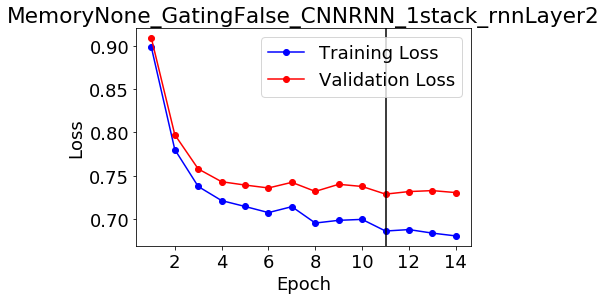

MemoryNone_GatingFalse_CNNRNN_2stack_rnnLayer2


INFO:Training:CNNRNN|12|False|True|2_2|1024|256_512|1|0.02667|0.09716


<Figure size 360x864 with 0 Axes>

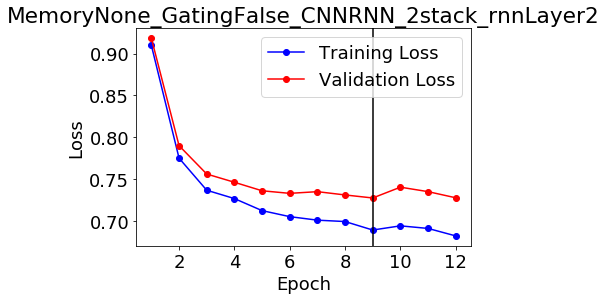

MemoryNone_GatingFalse_CNNRNN_3stack_rnnLayer2


INFO:Training:CNNRNN|13|False|True|2_2|1024|256_512_1024|1|0.02709|0.09747


<Figure size 360x864 with 0 Axes>

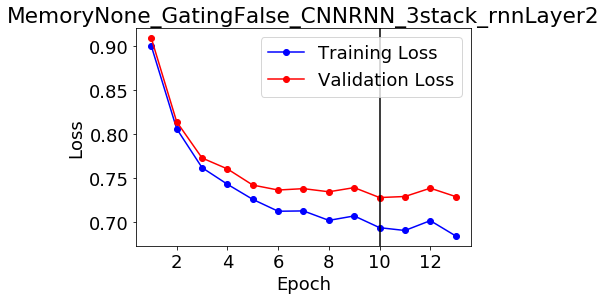

MemoryNone_GatingFalse_CNNRNN_1stack_rnnLayer3


INFO:Training:CNNRNN|9|False|True|2_2|1024|256|1|0.03075|0.10861


<Figure size 360x864 with 0 Axes>

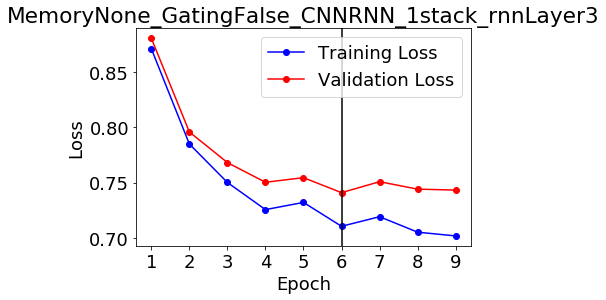

MemoryNone_GatingFalse_CNNRNN_2stack_rnnLayer3


INFO:Training:CNNRNN|16|False|True|2_2|1024|256_512|1|0.02884|0.10323


<Figure size 360x864 with 0 Axes>

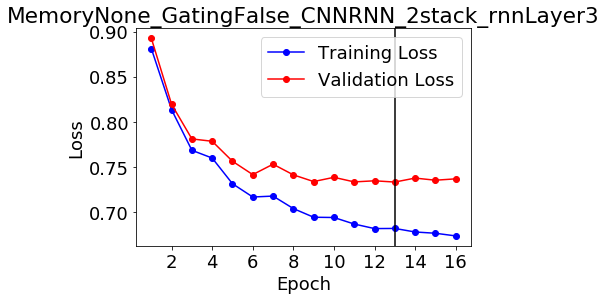

MemoryNone_GatingFalse_CNNRNN_3stack_rnnLayer3


INFO:Training:CNNRNN|12|False|True|2_2|1024|256_512_1024|1|0.02848|0.10045


<Figure size 360x864 with 0 Axes>

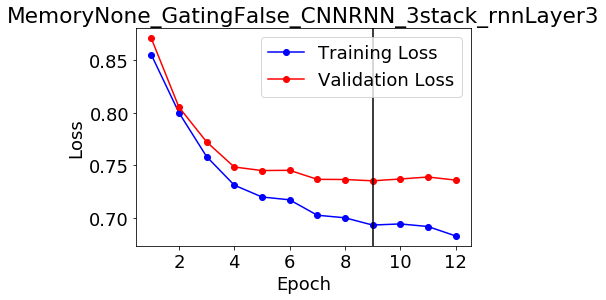

MemoryBi-GRU_GatingFalse_CNNRNN_1stack_rnnLayer1


INFO:Training:CNNRNN|13|False|True|2_2|1024|256|1|0.02799|0.10102


<Figure size 360x864 with 0 Axes>

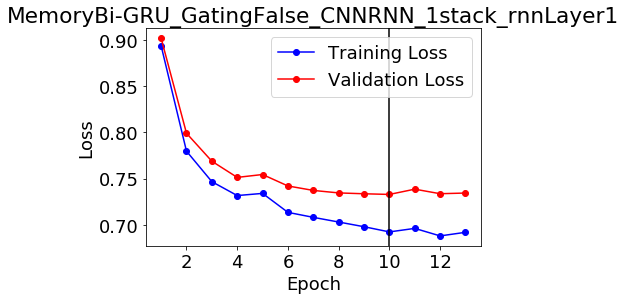

MemoryBi-GRU_GatingFalse_CNNRNN_2stack_rnnLayer1


INFO:Training:CNNRNN|12|False|True|2_2|1024|256_512|1|0.02676|0.10080


<Figure size 360x864 with 0 Axes>

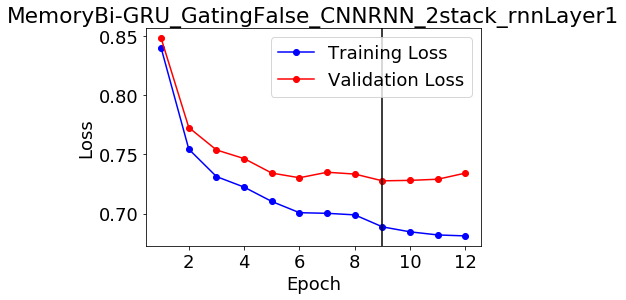

MemoryBi-GRU_GatingFalse_CNNRNN_3stack_rnnLayer1


INFO:Training:CNNRNN|15|False|True|2_2|1024|256_512_1024|1|0.02630|0.09754


<Figure size 360x864 with 0 Axes>

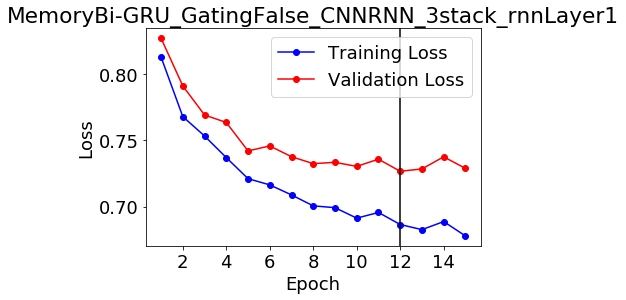

MemoryBi-GRU_GatingFalse_CNNRNN_1stack_rnnLayer2


INFO:Training:CNNRNN|12|False|True|2_2|1024|256|1|0.02753|0.09851


<Figure size 360x864 with 0 Axes>

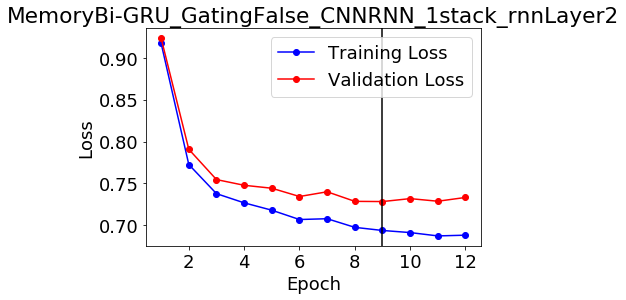

MemoryBi-GRU_GatingFalse_CNNRNN_2stack_rnnLayer2


INFO:Training:CNNRNN|13|False|True|2_2|1024|256_512|1|0.02675|0.09728


<Figure size 360x864 with 0 Axes>

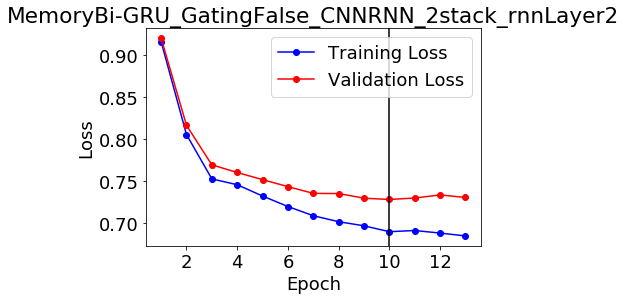

MemoryBi-GRU_GatingFalse_CNNRNN_3stack_rnnLayer2


INFO:Training:CNNRNN|12|False|True|2_2|1024|256_512_1024|1|0.02753|0.09904


<Figure size 360x864 with 0 Axes>

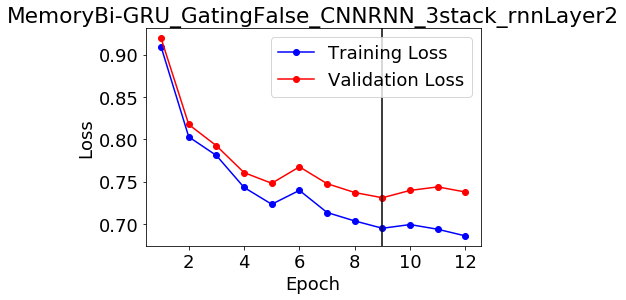

MemoryBi-GRU_GatingFalse_CNNRNN_1stack_rnnLayer3


INFO:Training:CNNRNN|17|False|True|2_2|1024|256|1|0.02624|0.09748


<Figure size 360x864 with 0 Axes>

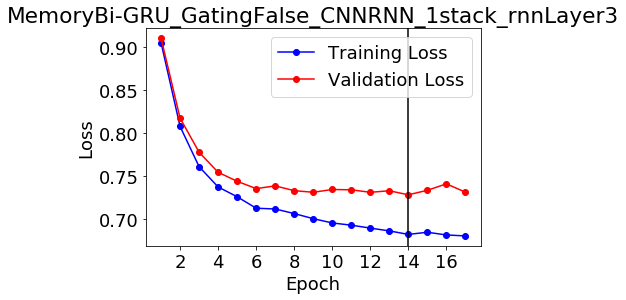

MemoryBi-GRU_GatingFalse_CNNRNN_2stack_rnnLayer3


INFO:Training:CNNRNN|14|False|True|2_2|1024|256_512|1|0.02672|0.09864


<Figure size 360x864 with 0 Axes>

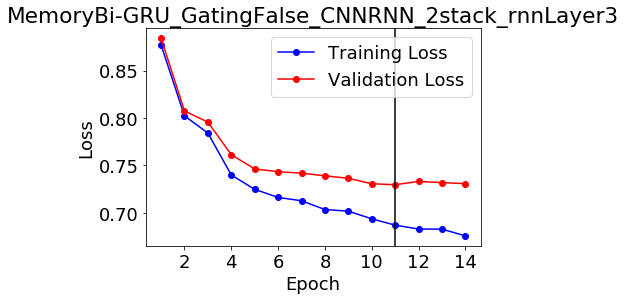

MemoryBi-GRU_GatingFalse_CNNRNN_3stack_rnnLayer3


INFO:Training:CNNRNN|10|False|True|2_2|1024|256_512_1024|1|0.02834|0.10190


<Figure size 360x864 with 0 Axes>

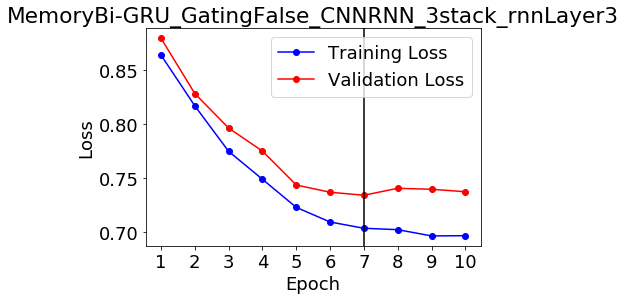

MemoryBi-LSTM_GatingFalse_CNNRNN_1stack_rnnLayer1


INFO:Training:CNNRNN|11|False|True|2_2|1024|256|1|0.02804|0.10048


<Figure size 360x864 with 0 Axes>

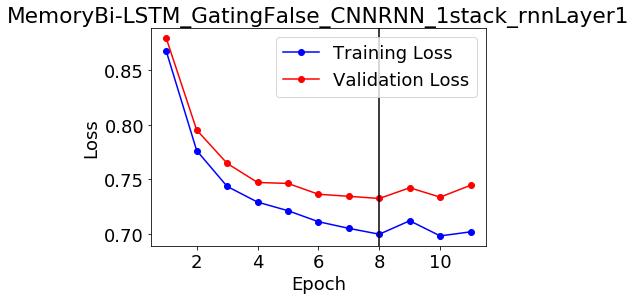

MemoryBi-LSTM_GatingFalse_CNNRNN_2stack_rnnLayer1


INFO:Training:CNNRNN|14|False|True|2_2|1024|256_512|1|0.02647|0.09839


<Figure size 360x864 with 0 Axes>

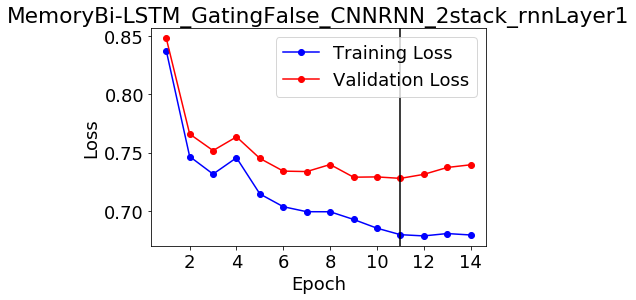

MemoryBi-LSTM_GatingFalse_CNNRNN_3stack_rnnLayer1


INFO:Training:CNNRNN|12|False|True|2_2|1024|256_512_1024|1|0.02666|0.09876


<Figure size 360x864 with 0 Axes>

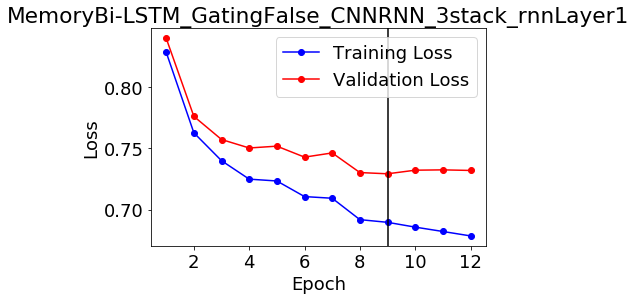

MemoryBi-LSTM_GatingFalse_CNNRNN_1stack_rnnLayer2


INFO:Training:CNNRNN|15|False|True|2_2|1024|256|1|0.02628|0.09751


<Figure size 360x864 with 0 Axes>

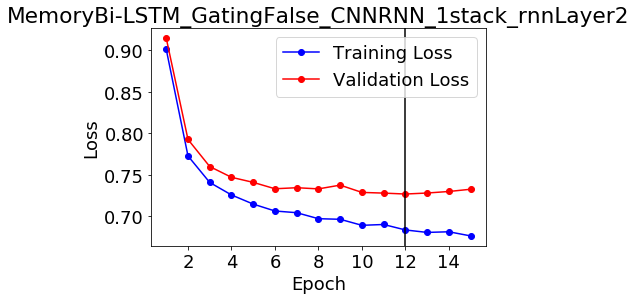

MemoryBi-LSTM_GatingFalse_CNNRNN_2stack_rnnLayer2


INFO:Training:CNNRNN|12|False|True|2_2|1024|256_512|1|0.02609|0.09649


<Figure size 360x864 with 0 Axes>

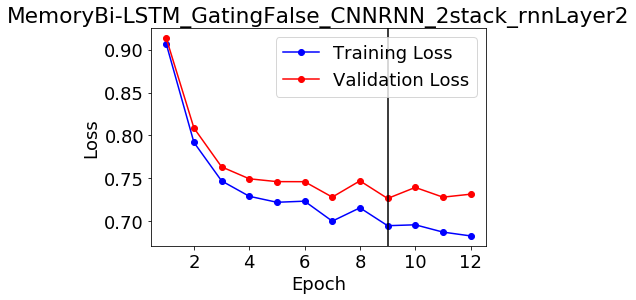

MemoryBi-LSTM_GatingFalse_CNNRNN_3stack_rnnLayer2


INFO:Training:CNNRNN|9|False|True|2_2|1024|256_512_1024|1|0.03082|0.10486


<Figure size 360x864 with 0 Axes>

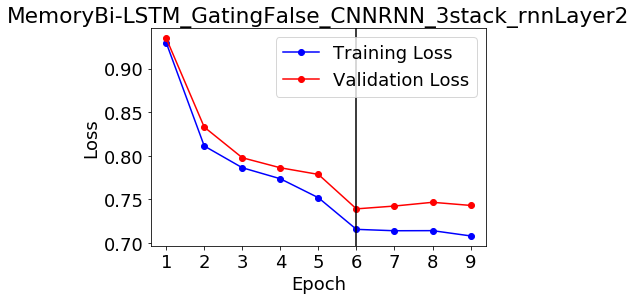

MemoryBi-LSTM_GatingFalse_CNNRNN_1stack_rnnLayer3


INFO:Training:CNNRNN|10|False|True|2_2|1024|256|1|0.02826|0.09930


<Figure size 360x864 with 0 Axes>

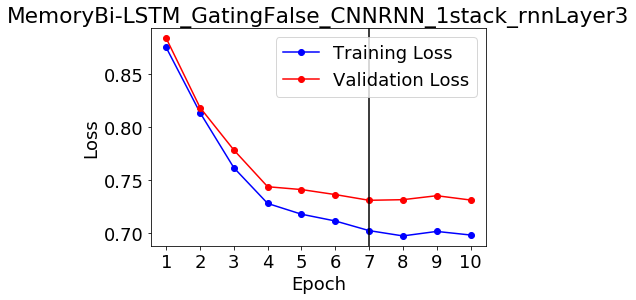

MemoryBi-LSTM_GatingFalse_CNNRNN_2stack_rnnLayer3


INFO:Training:CNNRNN|13|False|True|2_2|1024|256_512|1|0.02686|0.10057


<Figure size 360x864 with 0 Axes>

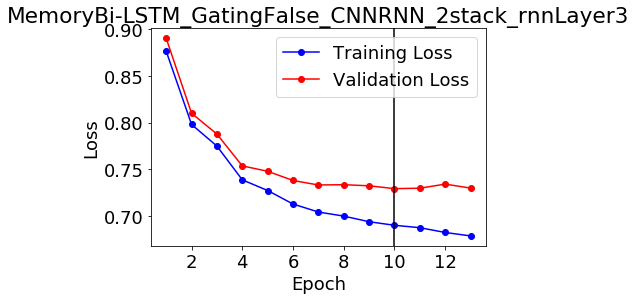

MemoryBi-LSTM_GatingFalse_CNNRNN_3stack_rnnLayer3


INFO:Training:CNNRNN|15|False|True|2_2|1024|256_512_1024|1|0.02837|0.09845


<Figure size 360x864 with 0 Axes>

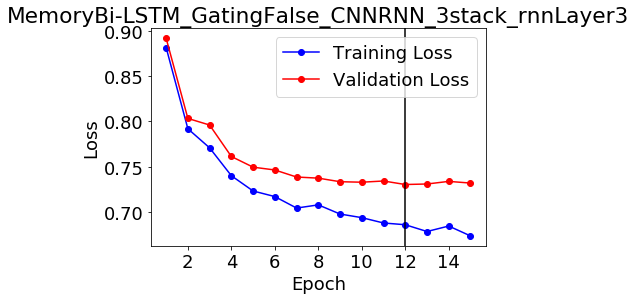

In [9]:
e = True
for mr in [None, 'Bi-GRU', 'Bi-LSTM']:
    for num_layers in [1, 2, 3]:
        for fn in [[256], [256, 512], [256, 512, 1024]]:
            testname = 'Memory{}_GatingFalse_CNNRNN_{}stack_rnnLayer{}'.format(mr, len(fn), num_layers)
            print(testname)
            testND, train_losses, dev_losses = stctrain.start_trainND(
                *dataND, 
                **fixed_paramsND, 
                Fnum=fn, gating=False, bn=True, method=ND.CNNRNN, num_layers=num_layers, memory_rnn_type=mr,
                evaluate=e,
            )

            show_train_history(testname, train_losses, dev_losses)
            datahelper.pred_to_submission(testND, bestDQAs[0], bestDQSs[0], bestDQEs[0], test_turns, testIDs, filename='{}.json'.format(testname))

In [10]:
# pickle.dump(testND, open('bestND190116.p', 'wb'))

In [11]:
stop

NameError: name 'stop' is not defined

## Test DQ

In [ ]:
memoryNDs = pickle.load(open('ResultPickle/memoryNDs.p', 'rb'))

In [ ]:
e = True
for rm in ['Bi-GRU', 'Bi-LSTM']:
    for l in [1]:
        for fn in [[1024], [512, 1024], [256, 512, 1024]]:
            testname = 'A-GatingTrue_{}stack_Memory{}_RNNLayer{}'.format(len(fn), rm, l)
            print(testname)
            bestDQA, train_lossesA, dev_lossesA = stctrain.start_trainDQ(
                *dataDQA, 
                **fixed_paramsDQA, 
                Fnum=fn, gating=True, bn=True, method=DQ.CNNCNN, memory_rnn_type=rm, num_layers=l,
                evaluate=e,
            )

#             show_train_history(testname, train_lossesA, dev_lossesA)

            testname = 'E-GatingTrue_{}stack_Memory{}_RNNLayer{}'.format(len(fn), rm, l)
            print(testname)
            bestDQE, train_lossesE, dev_lossesE = stctrain.start_trainDQ(
                *dataDQE, 
                **fixed_paramsDQE, 
                Fnum=fn, gating=True, bn=True, method=DQ.CNNCNN, memory_rnn_type=rm, num_layers=l,
                evaluate=e,
            )

#             show_train_history(testname, train_lossesE, dev_lossesE)

            testname = 'S-GatingTrue_{}stack_Memory{}_RNNLayer{}'.format(len(fn), rm, l)
            print(testname)
            bestDQS, train_lossesS, dev_lossesS = stctrain.start_trainDQ(
                *dataDQS, 
                **fixed_paramsDQS, 
                Fnum=fn, gating=True, bn=True, method=DQ.CNNCNN, memory_rnn_type=rm, num_layers=l,
                evaluate=e
            )

#             show_train_history(testname, train_lossesS, dev_lossesS)

            testname = 'GatingTrue_{}stack_Memory{}_RNNLayer{}'.format(len(fn), rm, l)
            datahelper.pred_to_submission(memoryNDs[0], bestDQA, bestDQS, bestDQE, test_turns, testIDs, filename='{}.json'.format(testname))
            print(testname, 'is saved')

In [ ]:
# pickle.dump(bestDQAs, open('memoryDQAs.p', 'wb'))
# pickle.dump(bestDQSs, open('memoryDQSs.p', 'wb'))
# pickle.dump(bestDQEs, open('memoryDQEs.p', 'wb'))

## Test NDF

In [ ]:
memoryND = pickle.load(open('ResultPickle/bestND190116.p', 'rb'))

In [ ]:
testNDmasked = [np.multiply(nd, mask) for nd, mask in zip(memoryND, test_masks)]

In [ ]:
dataDQA_NDF = [trainX, trainDQA, train_turns, trainND, devX, devDQA, dev_turns, devND, testX, test_turns, testNDmasked]
dataDQS_NDF = [trainX, trainDQS, train_turns, trainND, devX, devDQS, dev_turns, devND, testX, test_turns, testNDmasked]
dataDQE_NDF = [trainX, trainDQE, train_turns, trainND, devX, devDQE, dev_turns, devND, testX, test_turns, testNDmasked]

In [ ]:
method = DQNDF.CNNCNN
e = True
for rm in [None, 'Bi-GRU', 'Bi-LSTM']:
    for l in [1]:
        for fn in [[1024], [512, 1024], [256, 512, 1024]]:
            testname = 'DQNDFA-GatingTrue_{}stack_Memory{}_{}{}'.format(len(fn), rm, l, str(method).split()[1])
            print(testname)
            bestDQNDFA, train_lossesA, dev_lossesA = stctrain.start_trainDQ_NDF(
                *dataDQA_NDF, 
                **fixed_paramsDQA, 
                Fnum=fn, gating=True, bn=True, method=method, memory_rnn_type=rm, num_layers=l,
                evaluate=e,
            )

#             show_train_history(testname, train_lossesA, dev_lossesA)

            testname = 'DQNDFE-GatingTrue_{}stack_Memory{}_{}{}'.format(len(fn), rm, l, str(method).split()[1])
            print(testname)
            bestDQNDFE, train_lossesE, dev_lossesE = stctrain.start_trainDQ_NDF(
                *dataDQE_NDF, 
                **fixed_paramsDQE, 
                Fnum=fn, gating=True, bn=True, method=method, memory_rnn_type=rm, num_layers=l,
                evaluate=e,
            )

#             show_train_history(testname, train_lossesE, dev_lossesE)

            testname = 'DQNDFS-GatingTrue_{}stack_Memory{}_{}{}'.format(len(fn), rm, l, str(method).split()[1])
            print(testname)
            bestDQNDFS, train_lossesS, dev_lossesS = stctrain.start_trainDQ_NDF(
                *dataDQS_NDF, 
                **fixed_paramsDQS, 
                Fnum=fn, gating=True, bn=True, method=method, memory_rnn_type=rm, num_layers=l,
                evaluate=e
            )

#             show_train_history(testname, train_lossesS, dev_lossesS)

            testname = 'DQNDF-GatingFalse_{}stack_Memory{}_{}{}'.format(len(fn), rm, l, str(method).split()[1])
            datahelper.pred_to_submission(memoryND, bestDQNDFA, bestDQNDFS, bestDQNDFE, test_turns, testIDs, filename='{}.json'.format(testname))
            print(testname, 'is saved')

In [ ]:
# pickle.dump(bestDQANDFs, open('memoryDQANDFs.p', 'wb'))
# pickle.dump(bestDQSNDFs, open('memoryDQSNDFs.p', 'wb'))
# pickle.dump(bestDQENDFs, open('memoryDQENDFs.p', 'wb'))